# A* Motion Planning

In [1]:
# The autoreload extension will automatically load in new code as you edit files, 
# so you don't need to restart the kernel every time
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
from P1_astar import DetOccupancyGrid2D, AStar
from utils import generate_planning_problem

In [2]:
# from asl_tb3_lib.navigation import TrajectoryPlan
from utils import TrajectoryPlan

## Simple Environment
(Please submit resulting plot from this section in your write-up)
### Workspace

In [3]:
width = 10
height = 10
obstacles = [((6,7),(8,8)),((2,2),(4,3)),((2,5),(4,7)),((6,3),(8,5))]
occupancy = DetOccupancyGrid2D(width, height, obstacles)

### Starting and final positions

In [4]:
x_init = (1, 9)
x_goal = (9, 1)

### Run A* planning

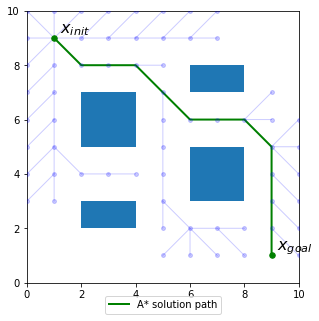

In [5]:
astar = AStar((0, 0), (width, height), x_init, x_goal, occupancy)
if not astar.solve():
    print("No path found")
else:
    plt.rcParams['figure.figsize'] = [5, 5]
    astar.plot_path()
    astar.plot_tree()

## Random Cluttered Environment
### Generate workspace, start and goal positions
(Try changing these and see what happens)

In [6]:
width = 10
height = 10
num_obs = 25
min_size = .5
max_size = 3

occupancy, x_init, x_goal = generate_planning_problem(width, height, num_obs, min_size, max_size)

### Run A* planning

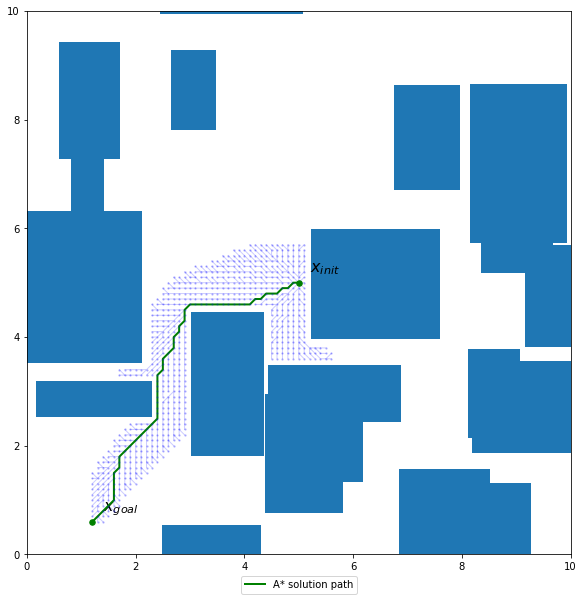

In [7]:
astar = AStar((0, 0), (width, height), x_init, x_goal, occupancy, resolution=0.1)
if not astar.solve():
    print("No path found! (This is normal, try re-running the block above)")
else:
    plt.rcParams['figure.figsize'] = [10, 10]
    astar.plot_path()
    astar.plot_tree(point_size=2)

# Smooth Trajectory 

In [8]:
def compute_smooth_plan(path, v_desired=0.15, spline_alpha=0.05) -> TrajectoryPlan:
    # Ensure path is a numpy array
    path = np.asarray(astar.path)

    # Compute and set the following variables:
    #   1. ts: 
    #      Compute an array of time stamps for each planned waypoint assuming some constant 
    #      velocity between waypoints. 
    #
    #   2. path_x_spline, path_y_spline:
    #      Fit cubic splines to the x and y coordinates of the path separately
    #      with respect to the computed time stamp array.
    #      Hint: Use scipy.interpolate.splrep
    
    ts = [0]

    if path is None or len(path) < 2:
        raise ValueError("Path must be a sequence of at least two waypoints.")
    for i in range(1, len(path)):
        dt = astar.distance(path[i], path[i-1]) / v_desired
        ts.append(ts[-1] + dt)
    ts = np.array(ts)

    path_x_spline = scipy.interpolate.splrep(ts, path[:, 0], s=spline_alpha)
    path_y_spline = scipy.interpolate.splrep(ts, path[:, 1], s=spline_alpha)
    
    return TrajectoryPlan(
        path=path,
        path_x_spline=path_x_spline,
        path_y_spline=path_y_spline,
        duration=ts[-1],
    )

In [9]:
# construct a trajectory plan
plan = compute_smooth_plan(astar.path)

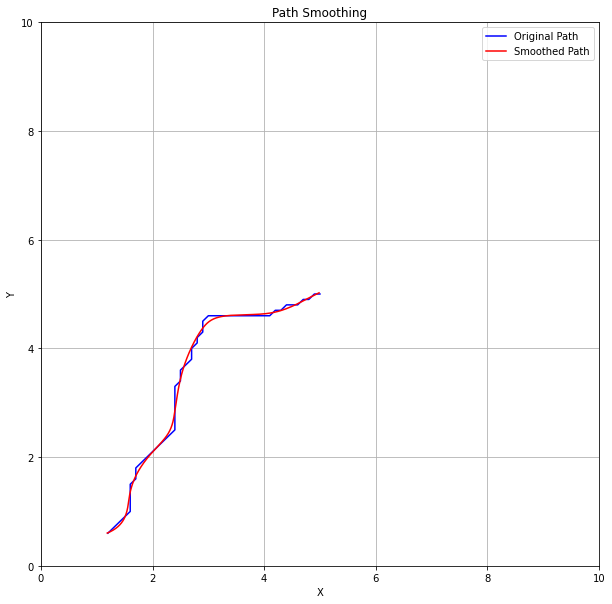

In [10]:
# plot AStar path v.s. smoothed path
astar_path = np.asarray(astar.path)
smoothed_path = plan.smoothed_path()

plt.plot(astar_path[:,0], astar_path[:,1], 'b-', label='Original Path')
plt.plot(smoothed_path[:, 0], smoothed_path[:, 1], 'r-', label='Smoothed Path')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim([0, width])
plt.ylim([0, height])
plt.title('Path Smoothing')
plt.grid()